In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb;
import time
import copy
from numpy import cos,sin,pi

In [2]:
# Robot dimensions
wheel_radius = 0.025
wheel_sep = 0.09
tail_dist = 0.075
L = 0.75
W = 0.5
dt = 0.08

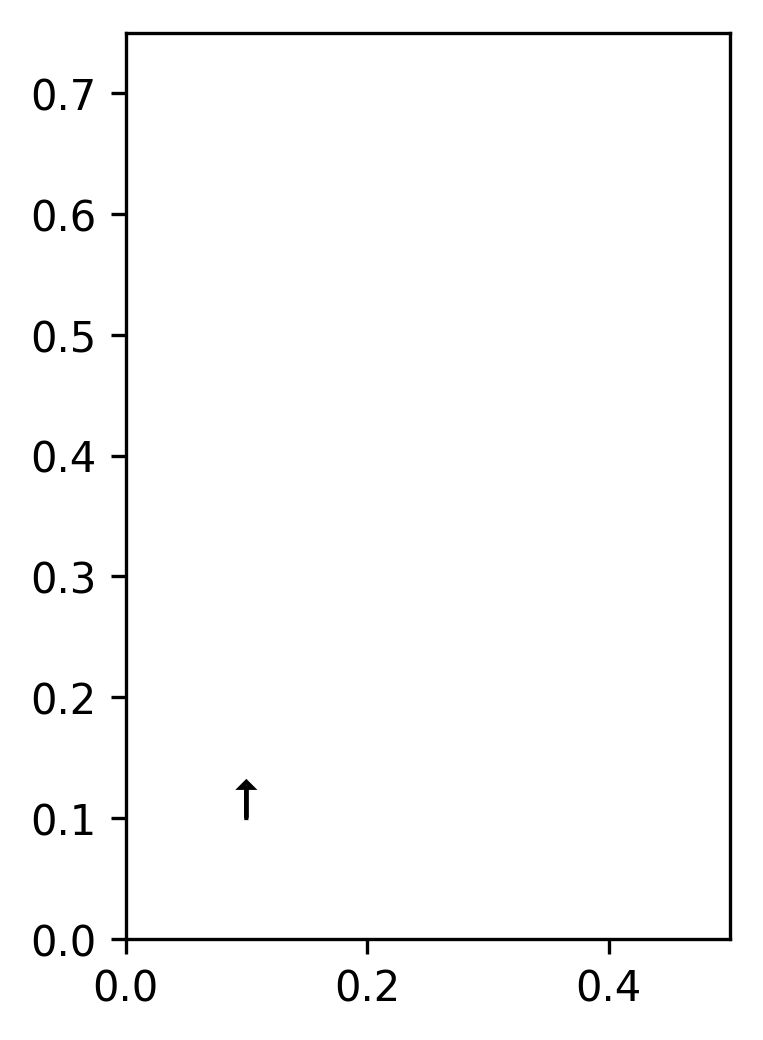

In [3]:
# Plot world
def show_world():
    plt.rcParams['figure.dpi'] = 300
    fig = plt.figure()
    ax=fig.add_subplot(111)
    plt.plot()
    
   
    plt.axis('equal')
    plt.axis([0,W,0,L])
    plt.gca().set_aspect('equal', adjustable='box')
    
    return ax
        
# Plot robot
def plot_robot(state,ax):      
    l = 0.025
    ax.arrow(state[0], state[1], l*np.cos(state[2]+pi/2), l*np.sin(state[2]+pi/2),width = 0.000001, head_width=0.01,head_length = 0.005)
            
  
ax = show_world()
plot_robot([0.1,0.1,0,0],ax)



In [4]:
# Calculated difference between angles
def get_angle_diff(a1,a2):
    ang_cw =  (a2 -a1)% (2*np.pi)
    ang_ccw = (- a2 + a1)% (2*np.pi)
    
    ang = np.minimum(ang_cw,ang_ccw) 
    if ang == ang_ccw:
        ang = - ang
    return ang

# Calculate distance between two points
def get_dist_diff(c1,c2):
    dist = np.sqrt(((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2))
    return dist

print(get_angle_diff(0,0.1))
print(get_angle_diff(0,-0.1))
print(get_angle_diff(0,0))

0.1
-0.1
-0.0


In [12]:
def forward_dynamic(state,controls):
    wl,wr = controls
    x,y,th,w = state
    vr = wr*wheel_radius
    vl = wl*wheel_radius
    wc = (vr-vl)/wheel_sep
    Rc = wheel_sep/2*(vr+vl)/(vr-vl)
    cx = x - Rc*sin(th+pi/2)
    cy = y + Rc*cos(th+pi/2)
    d = wc*dt
    xd = (x-cx)*cos(d) - (y-cy)*sin(d) + cx
    yd = (x-cx)*sin(d) + (y-cy)*cos(d) + cy
    thd = (th+d)%(2*pi)
    wd = wc
    return [xd,yd,thd,wd]

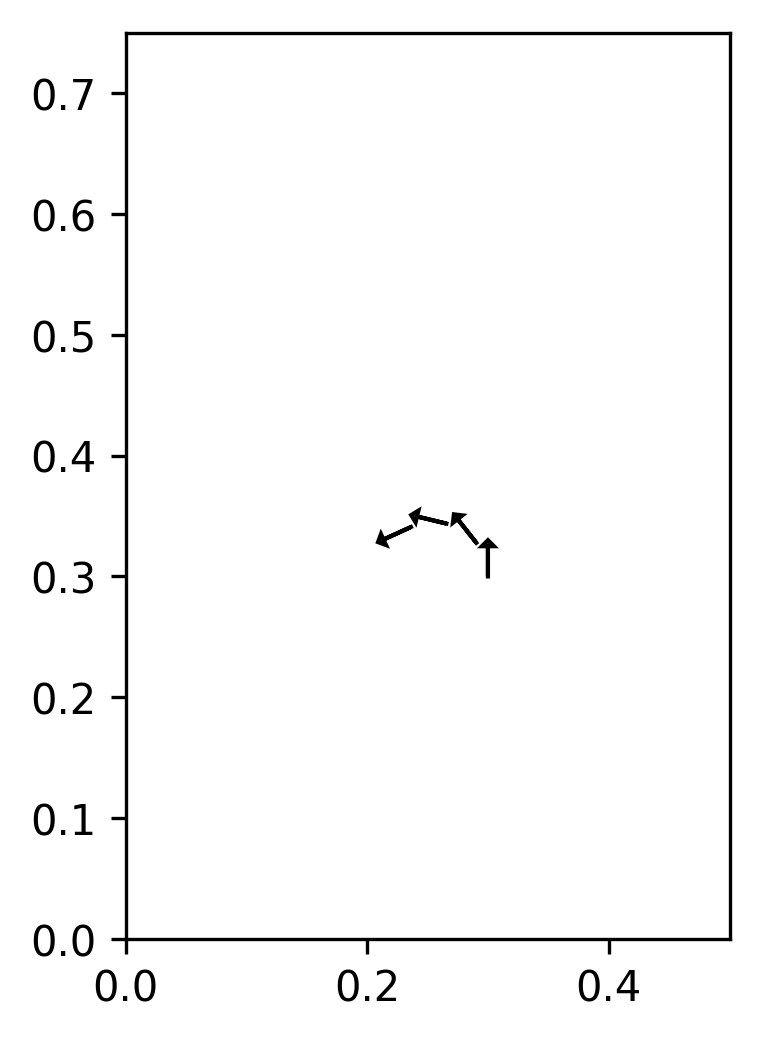

In [6]:
ax = show_world()
state = [0.3,0.3,0,0]
plot_robot(state,ax)
controls = [0,30]
for i in range(3):
    state = forward_dynamic(state,controls)
#     print(state)
    plot_robot(state,ax)

In [7]:
def state_to_sensor(state):
    get_dist_x = lambda x :  [(x - state[0])/ np.cos(state[2]) , (x - state[0])/ np.cos(state[2]+pi/2)]
    get_dist_y = lambda x :  [(x - state[1])/ np.sin(state[2]), (x - state[1])/ np.sin(state[2]+pi/2)]
    get_line_x = lambda d :  [state[0] + d[0] * np.cos(state[2]) , state[0] + d[1] * np.cos(state[2]+pi/2)]
    get_line_y = lambda d :  [state[1] + d[0] * np.sin(state[2]),  state[1] + d[1] * np.sin(state[2]+pi/2)]


    
    rN,fN = get_dist_y(L)
    xrN,xfN = get_line_x([rN,fN])
 
    rS,fS = get_dist_y(0)
    xrS,xfS = get_line_x([rS,fS])
    
    rW,fW = get_dist_x(W)
    yrW,yfW = get_line_y([rW,fW])
    
    rE,fE = get_dist_x(0)
    yrE,yfE = get_line_y([rE,fE])
    
    def check_x(x):
        return x<=W and x>=0

    def check_y(y):
        return y<=L and y>=0
    
    
    ra =  [rN,rS,rW,rE]
    fa = [fN,fS,fW,fE]
    
    rb = [check_x(xrN) and rN>=0,check_x(xrS) and rS>=0,check_y(yrW) and rW>=0,check_y(yrE) and rE>=0]
    fb = [check_x(xfN) and fN>=0,check_x(xfS) and fS>=0,check_y(yfW) and fW>=0,check_y(yfE) and fE>=0]
    if sum(rb)!=1:
        print(ra,rb)
        1/0
    if sum(fb)!=1:
        1/0
    r = ra[rb.index(True)]
    f = fa[fb.index(True)]
    th = (state[2]+pi/2)%(2*pi)
    w = state[3]
    return [f,r,th,w]

0.75 0.5
[0.3, 0.65, 3.141592653589793, 0]


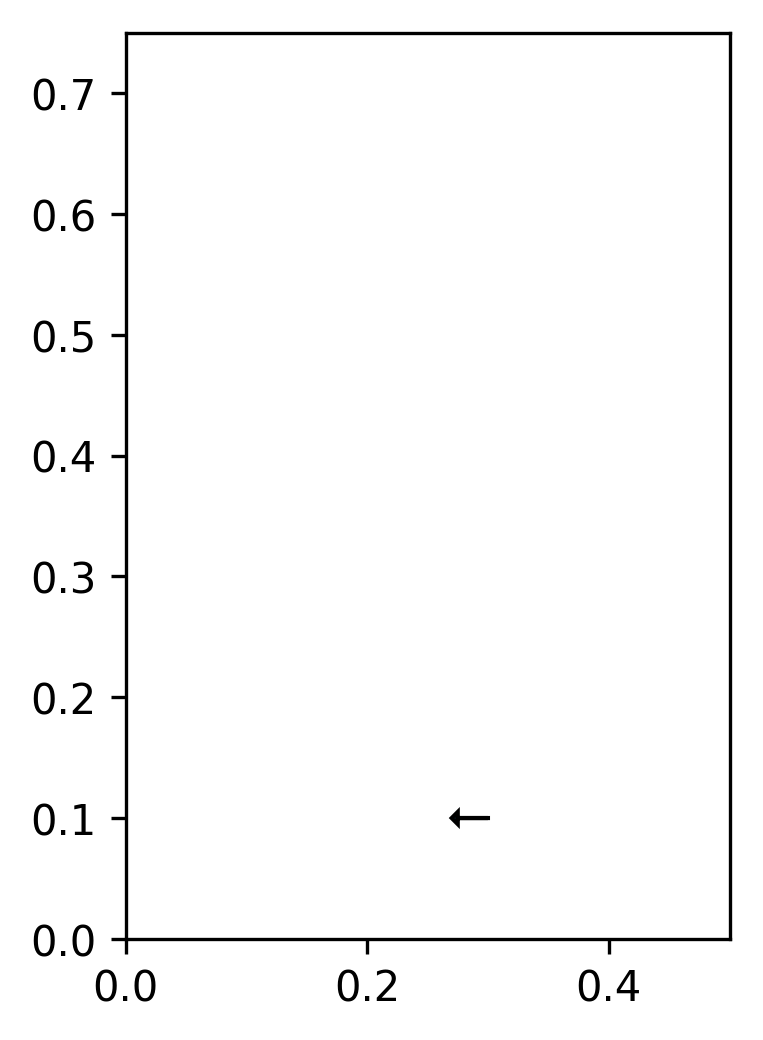

In [8]:
state = [0.3,0.1,np.pi/2,0]
print(L,W)
print(state_to_sensor(state))
ax = show_world()
plot_robot(state,ax)

In [9]:
def trace_traj(state,traj):
    state_seq = []
    obs_seq = []
    for c in traj:
        obs = state_to_sensor(state)
        state = forward_dynamic(state,c)
#         print(state)
        obs_seq.append(obs)
        state_seq.append(state)
    return (state_seq,obs_seq)

def plot_state_seq(states):
    ax = show_world()
    for state in states:
#         print(state)
        plot_robot(state,ax)

/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


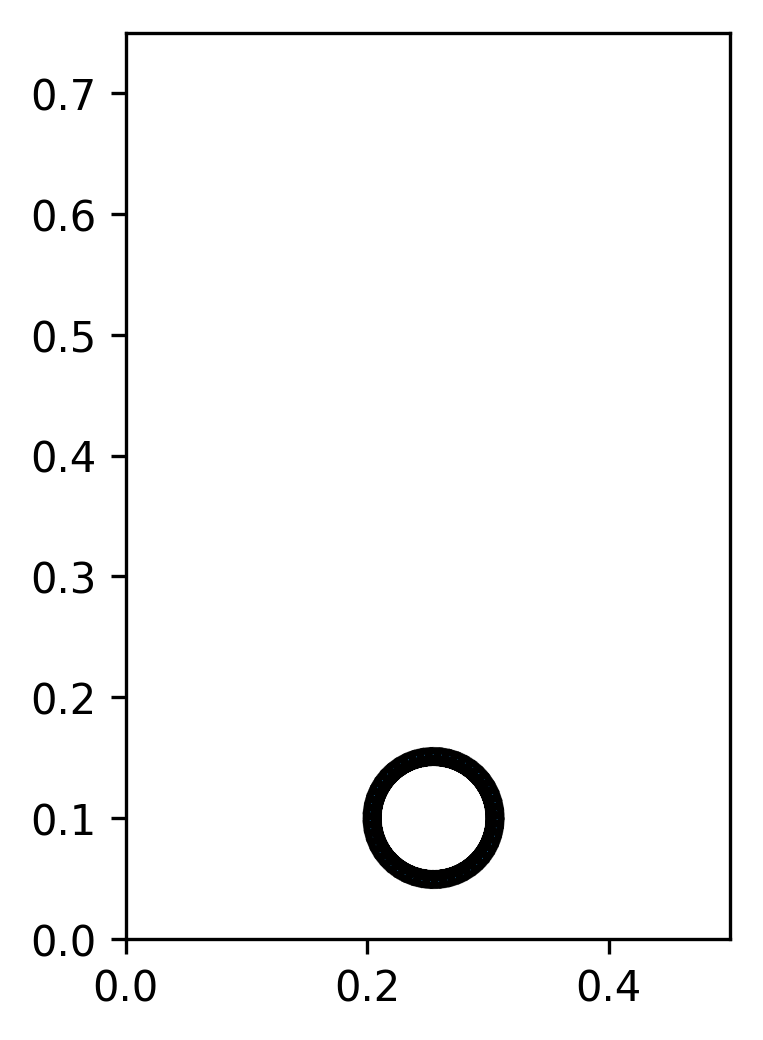

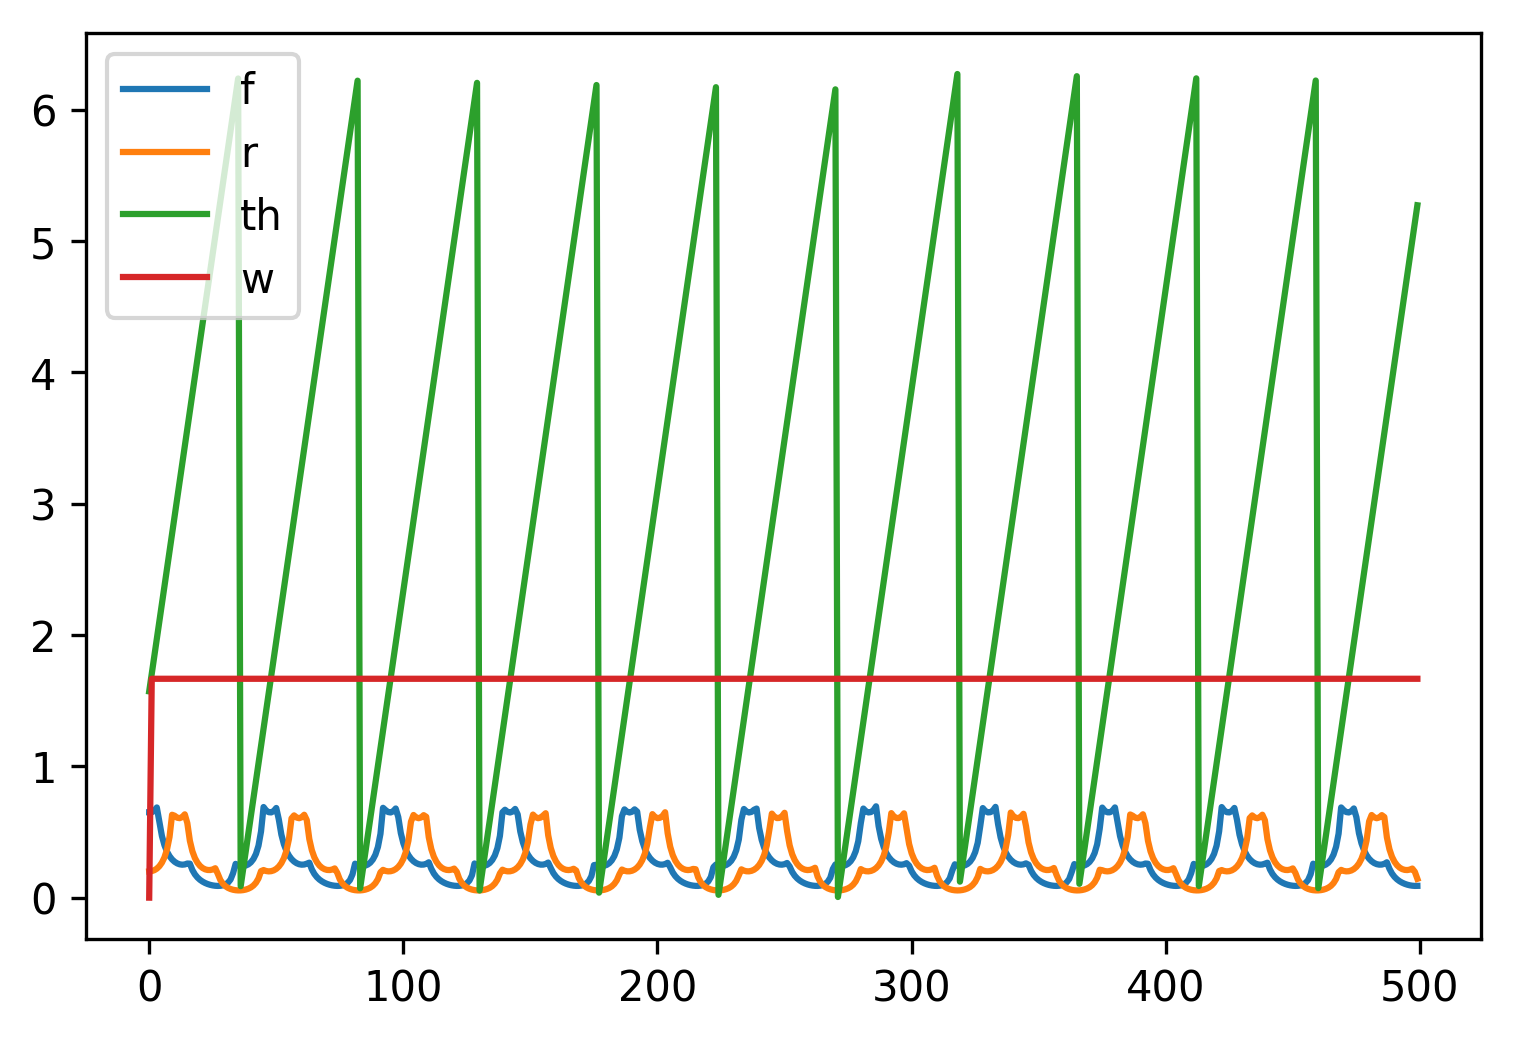

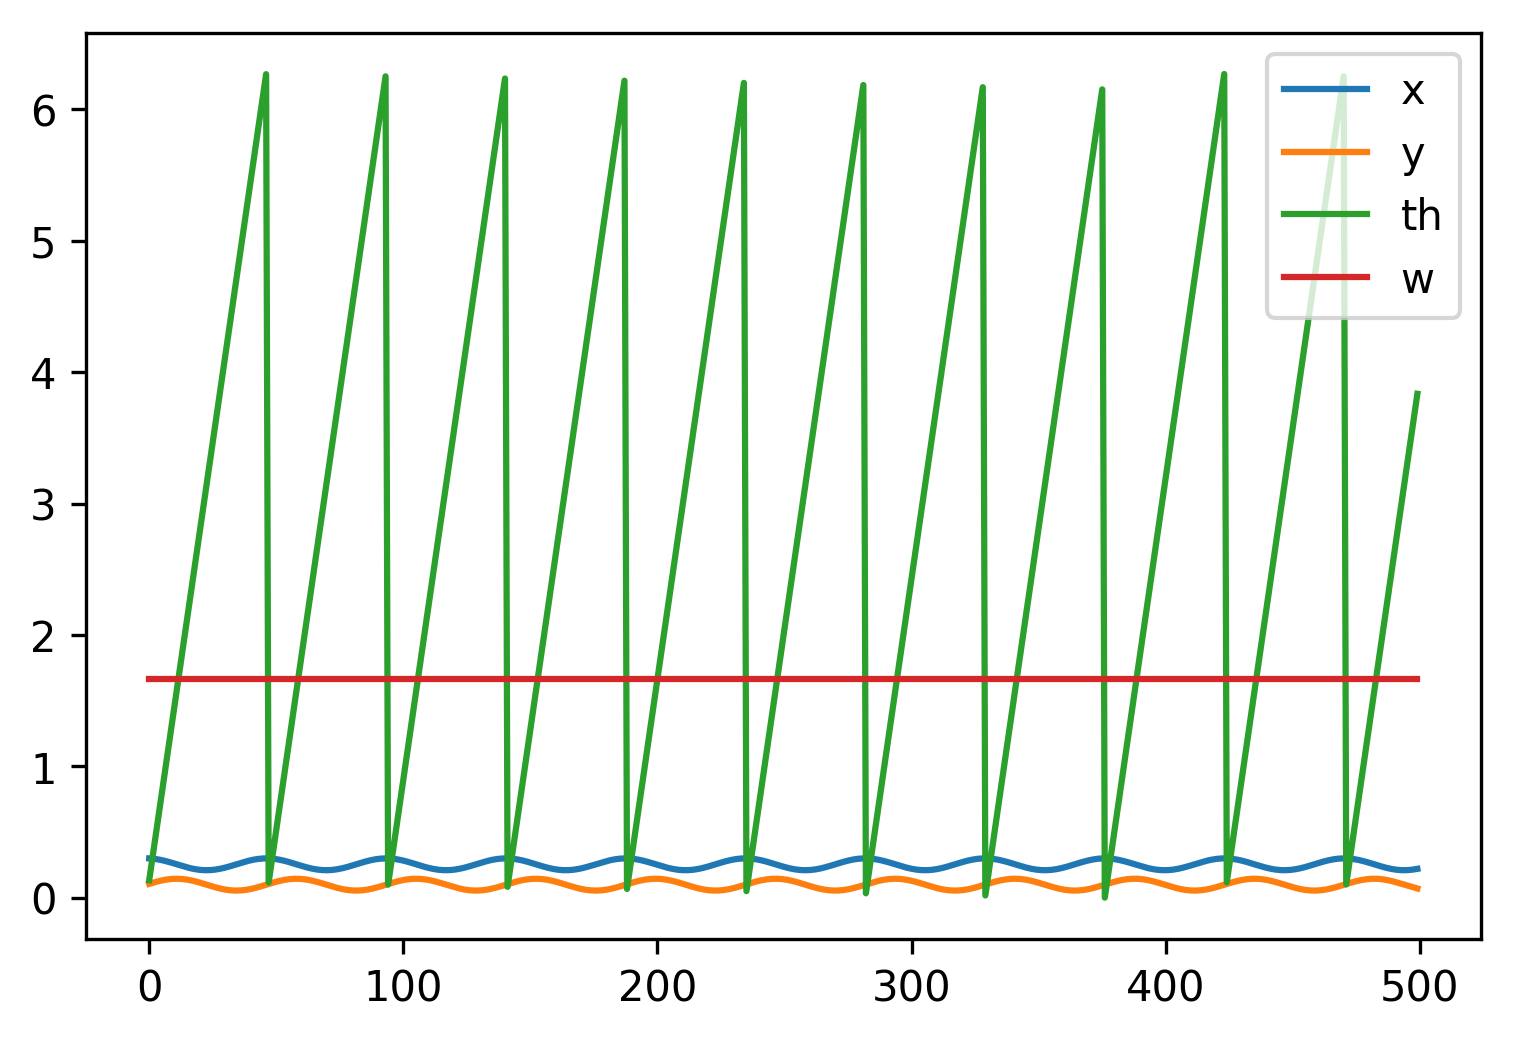

In [14]:
traj = [[0,6]]*500
state = [0.3,0.1,0,0]
state_seq,obs_seq = trace_traj(state,traj)
plot_state_seq(state_seq)
plt.figure()
plt.plot(np.array(obs_seq))
plt.legend(['f','r','th','w'])
plt.figure()
plt.plot(np.array(state_seq))
plt.legend(['x','y','th','w'])

In [11]:
for _ in range(100):
    print()